In [1]:
from zoish.feature_selectors.optunashap import OptunaShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
import lightgbm
import matplotlib.pyplot as plt
import optuna


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
[I 2022-08-09 14:34:04,888] A new study created in memory with name: no-name-3bdb1d7c-0a30-43a4-982a-c455e3860425


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
optuna_classification_lgb = OptunaShapFeatureSelector(
        # general argument setting        
        verbose=1,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=lightgbm.LGBMClassifier(),
        estimator_params={
        "max_depth": [4, 9],
        "reg_alpha": [0, 1],

        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=False,
        save_shap_summary_plot=True,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        test_size=0.33,
        with_stratified = False,
        performance_metric = 'f1',
        # optuna study init params
        study = optuna.create_study(
            storage = None,
            sampler = TPESampler(),
            pruner= HyperbandPruner(),
            study_name  = None,
            direction = "maximize",
            load_if_exists = False,
            directions  = None,
            ),
        study_optimize_objective_n_trials=10, 

)

[I 2022-08-09 14:34:05,816] A new study created in memory with name: no-name-5ee0f455-8e9c-469f-91dd-6dc16e5d4004
root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - LGBMClassifier()
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Setting value for estimator_params
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', optuna_classification_lgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for performance metric
root - INFO - Getting value for estimator_params
root - INFO - Getting value for verbose
root - INFO - Getting value for test_size
root - INFO - Getting value for random_state
root - INFO - Getting value for study
root - INFO - Getting value for study optimize objective
root - INFO - Getting value for study_optimize_objective_n_trials
root - INFO - Getting value for study_optimize_objective_timeout
root - INFO - Getting value for study_optimize_n_jobs
root - INFO - Getting value for study_optimize_catch
root - INFO - Getting value for study_optimize_callbacks
root - INFO - Getting value for study_optimize_gc_after_trial
root - INFO - Getting value for study_optimize_show_progress_bar
root - INFO - Getting value for with_stratified
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
A column-vector y w

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[I 2022-08-09 14:34:11,828] Trial 4 finished with value: 0.6945069065210409 and parameters: {'max_depth': 6, 'reg_alpha': 0.4313424984644407}. Best is trial 4 with value: 0.6945069065210409.


[75]	valid_0's binary_logloss: 0.287042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's binary_logloss: 0.287587
[80]	valid_0's binary_logloss: 0.286092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's binary_logloss: 0.286659
[75]	valid_0's binary_logloss: 0.28614
[87]	valid_0's binary_logloss: 0.287116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's binary_logloss: 0.285633
[98]	valid_0's binary_logloss: 0.286129
[81]	valid_0's binary_logloss: 0.285975
[76]	valid_0's binary_logloss: 0.286968
[76]	valid_0's binary_logloss: 0.287467
[90]	valid_0's binary_logloss: 0.286562
[76]	valid_0's binary_logloss: 0.286172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's binary_logloss: 0.285958
[89]	valid_0's binary_logloss: 0.285685
[88]	valid_0's binary_logloss: 0.287021
[LightGBM] [Warning] No further splits with positive gain, be

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[84]	valid_0's binary_logloss: 0.28604
[92]	valid_0's binary_logloss: 0.285636
[79]	valid_0's binary_logloss: 0.285828
[93]	valid_0's binary_logloss: 0.286407
[91]	valid_0's binary_logloss: 0.28694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's binary_logloss: 0.286596
[79]	valid_0's binary_logloss: 0.287438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's binary_logloss: 0.28633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's binary_logloss: 0.285887
[1]	valid_0's binary_logloss: 0.507099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's binary_logloss: 0.285956
[81]	valid_0's binary_logloss: 0.286531
[93]	valid_0's binary_logloss: 0.285619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's binary_logloss: 0.2

[I 2022-08-09 14:34:12,237] Trial 0 finished with value: 0.6962962962962964 and parameters: {'max_depth': 7, 'reg_alpha': 0.24831332199417255}. Best is trial 0 with value: 0.6962962962962964.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's binary_logloss: 0.285303
[88]	valid_0's binary_logloss: 0.286049
[83]	valid_0's binary_logloss: 0.285986
[95]	valid_0's binary_logloss: 0.286518
[83]	valid_0's binary_logloss: 0.286756
[4]	valid_0's binary_logloss: 0.43083
[84]	valid_0's binary_logloss: 0.286222
[98]	valid_0's binary_logloss: 0.286188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's binary_logloss: 0.286757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's binary_logloss: 0.285774
[97]	valid_0's binary_logloss: 0.285386
[89]	valid_0's binary_logloss: 0.285838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's binary_logloss: 0.286451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's binary_logloss: 0.285753
[99]	valid_0's binary_logloss: 0.286203
[5]	valid_0's binary_loglos

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
[I 2022-08-09 14:34:12,367] Trial 5 finished with value: 0.698433002878158 and parameters: {'max_depth': 7, 'reg_alpha': 0.87641304173815}. Best is trial 5 with value: 0.698433002878158.
[I 2022-08-09 14:34:12,457] Trial 2 finished with value: 0.6968238691049085 and parameters: {'max_depth': 7, 'reg_alpha': 0.1940010368741405}. Best is trial 5 with value: 0.698433002878158.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3540, number of negative: 11076
[100]	valid_0's binary_logloss: 0.28542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's binary_logloss: 0.285865
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[87]	valid_0's binary_logloss: 0.285829
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 14616, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's binary_logloss: 0.286298
[Ligh

[I 2022-08-09 14:34:12,656] Trial 1 finished with value: 0.6983721672518353 and parameters: {'max_depth': 8, 'reg_alpha': 0.06249632271356065}. Best is trial 5 with value: 0.698433002878158.


[96]	valid_0's binary_logloss: 0.285861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's binary_logloss: 0.406352
[91]	valid_0's binary_logloss: 0.286098
[91]	valid_0's binary_logloss: 0.286371
[92]	valid_0's binary_logloss: 0.285655
[11]	valid_0's binary_logloss: 0.352341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's binary_logloss: 0.39415
[97]	valid_0's binary_logloss: 0.285927
[92]	valid_0's binary_logloss: 0.286006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's binary_logloss: 0.286252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's binary_logloss: 0.383704
[93]	valid_0's binary_logloss: 0.285765
[98]	valid_0's binary_logloss: 0.285752
[12]	valid_0's binary_logloss: 0.346159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's binary_logloss: 0.374592
[93]	valid_0's binary_logloss:

[I 2022-08-09 14:34:12,785] Trial 7 finished with value: 0.6967370441458735 and parameters: {'max_depth': 7, 'reg_alpha': 0.5664124331200754}. Best is trial 5 with value: 0.698433002878158.
[I 2022-08-09 14:34:12,817] Trial 3 finished with value: 0.6959026888604354 and parameters: {'max_depth': 7, 'reg_alpha': 0.9692933430402788}. Best is trial 5 with value: 0.698433002878158.
[I 2022-08-09 14:34:12,823] Trial 6 finished with value: 0.6961822264998395 and parameters: {'max_depth': 7, 'reg_alpha': 0.5446897695976248}. Best is trial 5 with value: 0.698433002878158.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's binary_logloss: 0.330718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's binary_logloss: 0.285619
[18]	valid_0's binary_logloss: 0.320947
[99]	valid_0's binary_logloss: 0.285981
[99]	valid_0's binary_logloss: 0.286203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's binary_logloss: 0.327537
[100]	valid_0's binary_logloss: 0.285686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's binary_logloss: 0.317892
[19]	valid_0's binary_logloss: 0.324973
[100]	valid_0's binary_logloss: 0.285951
[100]	valid_0's binary_logloss: 0.286194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's binary_logloss: 0.32267
[20]	valid_0's binary_logloss: 0.315159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's binary_loglos

[I 2022-08-09 14:34:13,209] Trial 9 finished with value: 0.6936266580394694 and parameters: {'max_depth': 5, 'reg_alpha': 0.12717607780723628}. Best is trial 5 with value: 0.698433002878158.
[I 2022-08-09 14:34:13,312] Trial 8 finished with value: 0.7004461440407903 and parameters: {'max_depth': 9, 'reg_alpha': 0.6057217052678275}. Best is trial 8 with value: 0.7004461440407903.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's binary_logloss: 0.287143
[62]	valid_0's binary_logloss: 0.287076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's binary_logloss: 0.287226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's binary_logloss: 0.287243
[63]	valid_0's binary_logloss: 0.287017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's binary_logloss: 0.287046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's binary_logloss: 0.286936
[90]	valid_0's binary_logloss: 0.28699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's binary_logloss: 0.287042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's binary_logloss: 0.28693
[6

root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


LGBMClassifier


 99%|===================| 21697/21815 [01:05<00:00]        root - INFO - Getting value for plot shap summary
root - INFO - Getting value for save_shap_summary_plot
root - INFO - Getting value for n_features
matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/Users/h

.values =
array([[-9.82087190e-01, -2.02590565e-02,  4.08174862e-01, ...,
        -3.44431433e-02, -9.92635536e-02,  6.56976257e-03],
       [-3.99703489e-01, -1.33227385e-03,  1.27663527e-01, ...,
        -3.14786714e-02,  2.12599157e-02,  1.66434159e-03],
       [ 2.44392346e-01,  6.66005607e-02, -9.73465466e-03, ...,
        -3.19232490e-02, -1.21045743e-02, -1.71174279e-03],
       ...,
       [ 7.74162756e-01,  2.89649603e-02, -1.57771213e-01, ...,
        -2.47380363e-02,  5.46867634e-01,  2.92384695e-03],
       [-4.33872034e-01,  4.62365664e-02, -2.76045269e-01, ...,
        -3.15084421e-02,  5.85706930e-01,  3.85223719e-03],
       [-2.17703656e+00, -1.81279459e-02, -1.61751304e-01, ...,
        -3.10614149e-02, -4.41080228e-02, -7.14015646e-03]])

.base_values =
array([-2.60644663, -2.60644663, -2.60644663, ..., -2.60644663,
       -2.60644663, -2.60644663])

.data =
array([[    24,      1, 228649, ...,      0,     38,      1],
       [    28,      1, 122540, ...,      0,    

matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kailasa.ttc', name='Kailasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/InaiMathi-MN.ttc', name='InaiMathi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SukhumvitSet.ttc', name='Sukhumvit Set', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMono.ttf', name='.SF NS Mono', style='normal', variant='normal', weight=295, stretch='normal', size='scalable')) = 10.14975
matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/System/Library/Fonts/Suppleme

                 0         1
0              age  0.681965
1        workclass   0.05842
2           fnlwgt  0.108076
3        education  0.031598
4    education-num   0.39739
5   marital-status  0.724476
6       occupation  0.335072
7     relationship  0.421241
8             race  0.073151
9              sex  0.171154
10    capital-gain  0.482623
11    capital-loss  0.107784
12  hours-per-week  0.327881
13  native-country  0.015106
       column_name shap_importance
0              age        0.681965
1        workclass         0.05842
2           fnlwgt        0.108076
3        education        0.031598
4    education-num         0.39739
5   marital-status        0.724476
6       occupation        0.335072
7     relationship        0.421241
8             race        0.073151
9              sex        0.171154
10    capital-gain        0.482623
11    capital-loss        0.107784
12  hours-per-week        0.327881
13  native-country        0.015106
       column_name shap_importance
5   m

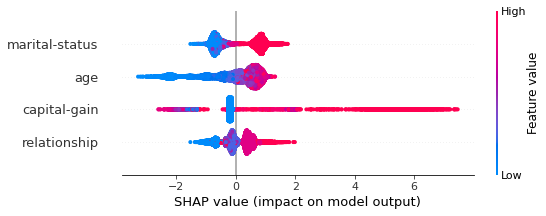

In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.3174030658250676
Classification report : 
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      8158
           1       0.71      0.20      0.32      2588

    accuracy                           0.79     10746
   macro avg       0.75      0.59      0.60     10746
weighted avg       0.77      0.79      0.74     10746

Confusion matrix : 
[[7947  211]
 [2060  528]]
